<h1><center> Portfolio Optimization </center></h1>
<h4><center> Anthony Li </center></h4>
<h4><center> September 2023 </center></h4>

## Introduction
Portfolio optimization is a fundamental concept in finance that involves designing an investment portfolio with the goal of achieving the best possible trade-off between risk and return. There have been many techniques and studies in this area. The most popular methods involve maximizing sharpe ratio, minimising variance, and portfolio efficient frontiers.

In this project, the focus is to explore different methods to calculate the optimal portfolio weights across the SP500 component stocks. We will fix the rebalancing frequency to monthly across all methods and use a 12 month training period.

We will use daily returns for calculating the expected return for each stock and the covariance matrix. For calculating the monthly returns of the portfolio, we will used the monthly returns for each stock. The monthly returns are calculated as the percentage change between the last trading days of each month.



## Libraries and Data Preprocessing

In [141]:
# Importing Libraries
import statsmodels.api as sm
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
# Import optimization libraries
from scipy.optimize import minimize

In [41]:
# Connecting Google Collaboratory to Google Drive folder
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir("./gdrive/My Drive/Quantitative Finance Projects/Statistical Arbitrage Trading Strategy/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


FileNotFoundError: ignored

In [143]:
# Importing .csv of the prices of all stocks in the S&P500
Prices = pd.read_csv("price.csv", index_col=0)

# For simplicity, dropping all stocks that have any NaN
Prices =Prices.dropna(axis=1)

Prices.head()

,A,AAL,AAP,AAPL,ABC,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XRAY,YUM,ZBH,ZBRA,ZION
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,20.434929,4.496876,38.432693,6.572423,22.101795,19.778837,7.994444,32.970871,37.090000,23.694084,...,70.913910,28.994482,41.963718,13.932555,43.185623,32.782581,19.900911,53.282867,28.670000,11.580979
2010-01-05,20.212959,5.005957,38.204258,6.583786,21.944103,19.619041,7.967778,33.174648,37.700001,23.656675,...,70.754967,29.609983,44.515926,13.767320,43.354244,32.392876,19.832848,54.969589,28.620001,11.989312
2010-01-06,20.141132,4.798555,38.537392,6.479064,21.736616,19.727999,7.933333,33.527321,37.619999,23.611784,...,71.894043,29.282593,43.932011,13.793758,43.728970,32.606281,19.691063,54.951843,28.400000,13.031859
2010-01-07,20.115025,4.939965,38.527885,6.467087,21.388039,19.891426,7.886667,33.495968,36.889999,23.424749,...,71.682121,29.151625,44.870213,13.734278,43.591564,33.033108,19.685392,56.212440,27.690001,14.491426
2010-01-08,20.108498,4.845690,38.680153,6.510081,21.620419,19.993120,7.871111,33.362751,36.689999,23.559416,...,71.602646,28.883154,44.548744,13.740885,43.416687,33.033108,19.691063,55.031742,27.600000,14.256856


In [144]:
# Convert the 'Date' column to a datetime index
Prices['Date'] = pd.to_datetime(Prices.index)
Prices.set_index('Date', inplace=True)

# Calculate the monthly returns
monthly_returns = Prices.resample('M').ffill().pct_change()

In [145]:
# Calculate daily returns
returns = Prices.pct_change().dropna()

In [146]:
dates = {'date': Prices.index.values}
dates = pd.DataFrame(dates)

dates['date'] = pd.to_datetime(dates['date'])

dates['year_month'] = dates['date'].dt.to_period('M')

In [147]:
returns['YEAR_MONTH'] = dates['year_month'].values[1:]
Prices['YEAR_MONTH'] = dates['year_month'].values
monthly_returns['YEAR_MONTH'] = returns['YEAR_MONTH'].unique()

In [148]:
Months = returns['YEAR_MONTH'].unique()
Months

<PeriodArray>
['2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06', '2010-07',
 '2010-08', '2010-09', '2010-10',
 ...
 '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09',
 '2019-10', '2019-11', '2019-12']
Length: 120, dtype: period[M]

## Table of Contents
- [1. Modern Portfolio Theory](#section-1)
- [2. Mean-Variance Optimization](#section-2)
  - [2.1 Minimum Variance](#subsection-2-1)
  - [2.2 Maximum Sharpe Ratio](#subsection-2-1)
  - [2.3 Efficient Frontier](#subsection-2-1)

- [3. Cointegration Approach: Annual Cointegration and Stop-Loss Implementation](#section-3)
  - [3.1 Identifying Cointegrating Pairs Annually](#subsection-3-1)
  - [3.2 Calculating Strategy Returns and Implementing a Stop-loss](#subsection-3-2)
  - [3.3 Performance and Analysis](#subsection-3-3)

## 1 Modern Portfolio Theory
Modern Portfolio Theory (MPT) is a foundational concept in finance developed by Harry Markowitz in the 1950s. It provides a framework for optimizing investment portfolios by considering the trade-off between risk and return. Here's a summary of Modern Portfolio Theory:

**Key Concepts:**

1. **Diversification:** MPT emphasizes the benefits of diversifying investments across a mix of assets rather than concentrating in a single asset. Diversification can reduce portfolio risk while maintaining or enhancing returns.

2. **Risk and Return Relationship:** MPT recognizes that investors seek to maximize returns while minimizing risk. It defines risk as the volatility or standard deviation of an asset's returns and suggests that investors can achieve higher expected returns by accepting more risk.

3. **Efficient Frontier:** MPT introduces the concept of the efficient frontier, a set of portfolios that offer the highest expected return for a given level of risk or the lowest risk for a given level of return. Portfolios on the efficient frontier are considered optimal.

4. **Mean-Variance Optimization (MVO):** MPT's cornerstone is MVO, which aims to find the optimal portfolio by considering the expected returns and covariances of assets. MVO seeks the portfolio that maximizes return or minimizes risk, given an investor's risk tolerance.

5. **Asset Correlations:** MPT acknowledges that the correlation and covariance between asset returns play a crucial role in determining portfolio risk. Negative or low correlations between assets enhance diversification benefits.



## 2 Mean-Variance Optimization
In mean-variance optimization, we measure risk as the variance of the portfolio returns and the return to be the expected portfolio return. The objective is to maximize the expected return while minimizing the volatility of return.

**Key Concepts:**

1. **Expected Return (Mean):** MVO starts by estimating the expected return for each asset in the portfolio. This represents the average or most likely return an investor can expect to earn from each asset.

2. **Risk (Variance or Standard Deviation):** MVO quantifies risk as the variance or standard deviation of returns for each asset. Higher risk assets have greater variability in returns.

3. **Covariance Matrix:** MVO considers the relationships between asset returns by calculating the covariance between pairs of assets. A positive covariance indicates that assets tend to move in the same direction, while a negative covariance suggests they move in opposite directions.

### 2.1 Minimium Variance Portfolio
The Minimum Variance Portfolio (MVP) is a specific portfolio within the context of Modern Portfolio Theory (MPT). It is a portfolio that is constructed to minimize the overall portfolio variance, or equivalently, the portfolio's standard deviation. The MVP represents the portfolio with the lowest possible level of risk for a given set of assets or asset classes.

Key characteristics of the Minimum Variance Portfolio include:

1. **Risk Minimization:** The primary objective of the MVP is to minimize portfolio risk. It seeks to achieve the lowest possible level of volatility or standard deviation of returns.

2. **Diversification:** The MVP typically achieves its risk reduction through diversification. By allocating investments across different assets with low or negative correlations, it reduces the portfolio's sensitivity to the price movements of any single asset.

3. **Efficient Frontier:** The MVP is one point on the Efficient Frontier, a curve that represents all possible portfolios that offer the highest expected return for a given level of risk or the lowest risk for a given level of expected return. The Efficient Frontier is derived from Mean-Variance Optimization (MVO), which considers the trade-off between risk and return.

4. **Weighting Scheme:** The asset allocation or weighting of assets in the MVP depends on the covariance matrix of asset returns. The assets with lower correlations and lower individual volatilities will typically receive higher allocations in the MVP.

6. **Risk-Return Trade-Off:** While the MVP minimizes risk, it may not offer the highest expected return. The MVP is considered the portfolio of choice for extremely risk-averse investors who prioritize capital preservation over return maximization.

It's important to note that the Minimum Variance Portfolio is just one point on the Efficient Frontier, and investors may choose portfolios that lie on the Efficient Frontier based on their individual risk tolerance and return objectives. The trade-off between risk and return is a central concept in portfolio management, and the MVP represents the extreme end of risk minimization within the context of MPT.

In [ ]:
# Define an optimization function to minimize portfolio variance
def objective(weights):
    portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return portfolio_variance

In [ ]:
for month in Months[12:]:

  training_months = Months[ (Months < month) & (Months > month-13)]

  returns_training = returns[returns['YEAR_MONTH'].isin(training_months)]

  # Calculate the covariance matrix of returns
  cov_matrix = returns_training.cov()

  # Calculate the mean returns for each stock
  mean_returns = returns_training.mean()

  # Number of assets (stocks)
  num_assets = len(mean_returns)

  # Define an array of equal initial weights for the portfolio
  initial_weights = np.ones(num_assets) / num_assets

  # Set constraints for the optimization (sum of weights must equal 1)
  constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

  # Set bounds for the weights (0 <= weight <= 1)
  bounds = tuple((0, 1) for asset in range(num_assets))

  # Run the optimization to find minimum variance portfolio weights
  result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

  # Extract the optimized weights
  optimal_weights = result.x

  strategy1_returns.loc[month]['returns'] = (optimal_weights * monthly_returns[monthly_returns['YEAR_MONTH'] == month].iloc[:,:-1]).sum(axis=1)

In [160]:
strategy1_returns_cum = strategy1_returns.astype(float)

strategy1_returns_cum = (1 + strategy1_returns_cum['returns']).cumprod() - 1

equal_weight_returns =  monthly_returns[12:].sum(axis=1)/num_assets

equal_weight_returns = (1 + equal_weight_returns).cumprod() - 1

<ipython-input-160-b08ff186125d>:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  equal_weight_returns =  monthly_returns[12:].sum(axis=1)/num_assets


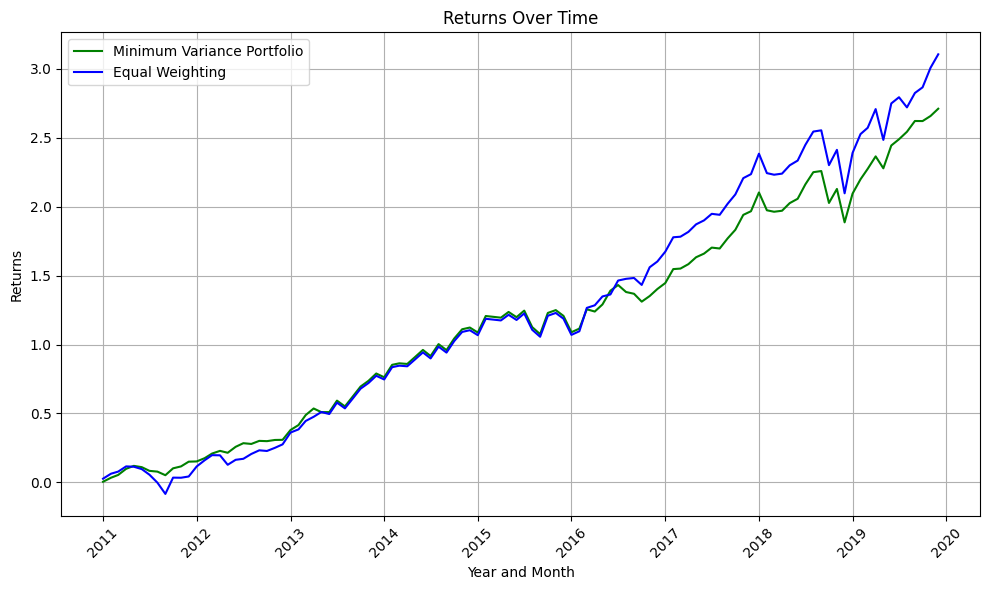

In [165]:
# Plot the returns against the year and month
plt.figure(figsize=(10, 6))
plt.plot(strategy1_returns_cum.index.to_timestamp(), strategy1_returns_cum, linestyle='-', label='Minimum Variance Portfolio', color='green')
plt.plot(strategy1_returns_cum.index.to_timestamp(), equal_weight_returns, color='blue', label='Equal Weighting')
plt.xlabel('Year and Month')
plt.ylabel('Returns')
plt.title('Returns Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(loc='upper left')
plt.show()

### 2.2 Maximum Sharpe Ratio

### 2.3 Efficient Portfolio Frontier

## Categorising into K groups and Portfolio Optimisation of each group

## Kalman Filter for mean-variance optimisation

## Dynamic Asset Allocation - adjust risk appetite based on economic signals

## Estimating Covariance matrix better - Kalman Filters

## Using DCC: Dynamic Conditional Correlation Models

## Covariance Matrix: PCA

## Comparison of twitter sp500 sentiment index and realised value (only available after 2018)